In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

In [2]:
import sklearn
from sklearn.linear_model import LinearRegression
#rom sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LassoLars

from sklearn.linear_model import TweedieRegressor

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [3]:
def get_ranks(good_df,ypred):
    cutoff=0.2
    #print (codedata,ypred,ydata)
    #print (len(ypred),len(good_df.mm.to_list()))
    d = {'code':good_df.code.to_list(),'pred':ypred,
         "dockQ":good_df.dockQ.to_list(),"params":good_df.params.to_list(),
        "mm":good_df.mm.to_list()}
    res_df=pd.DataFrame(d).sort_values("pred")
    #res_df.sort_values("CODE")

    i=0
    sumdiff=0
    mmdiff=0
    correct=0
    for code in res_df.code.unique():
        topranked=res_df.loc[res_df.code==code].sort_values("pred")["dockQ"][-1:].max()
        best=res_df.loc[res_df.code==code]["dockQ"].max()
        mmtop=res_df.loc[res_df.code==code].sort_values("pred")["mm"][-1:].max()
        mmbest=res_df.loc[res_df.code==code]["mm"].max()
        #print (code,topranked,best)
        if best>cutoff:
            i+=1
            sumdiff+=best-topranked
            mmdiff+=mmbest-mmtop
            if topranked>cutoff:
                correct+=1
    #print (i,correct,round(sumdiff/i,3))            
    return (i,correct,sumdiff,mmdiff)

In [4]:
reg = LinearRegression()
#reg=RandomForestClassifier(n_estimators=10)
#reg=LassoLars(alpha=.1)
#reg = TweedieRegressor(power=1, alpha=0.5, link='log')
#reg=TheilSenRegressor(random_state=42)
#reg=RANSACRegressor(random_state=42)
#reg=HuberRegressor()

In [5]:
df=pd.read_csv("~/Downloads/summary.csv",sep=",")
df=df.dropna()
#df.JHparams.unique()

In [6]:
sns.set(style="whitegrid")

In [7]:
df["name"]
df.keys()

Index(['name', 'JHparams', 'lenA', 'lenB', 'msa', 'msaA', 'msaB', 'cdhit',
       'dockQ', 'fnat', 'iRMS', 'LRMS', 'fnonnat', 'mm', 'tmA', 'tmB', 'long',
       'med', 'longPPV', 'medPPV', 'longA', 'medA', 'longPPVA', 'medPPVA',
       'longB', 'medB', 'longPPVB', 'medPPVB', 'short', 'shortPPV', 'shortA',
       'shortPPVA', 'shortB', 'shortPPVB', 'shortpdb', 'medpdb', 'longpdb',
       'avprob', 'auc', 'evalue', 'seqid', 'hhprob', 'hhevalue', 'hhscore',
       'rank'],
      dtype='object')

In [8]:

df["code"]=df["name"].str[:4]
df["CODE"]=df["code"]
df["params"]=df["JHparams"]

In [9]:
r=re.compile("^PDB|^pdb|^TMd|gramm")
datasets=df.JHparams.unique()
notRosettaset=list(filter(r.match, datasets))
df2=df.loc[~df.JHparams.isin(notRosettaset)].copy()
df2.JHparams="trRosetta"
df2.params="trRosetta"


In [10]:
df=pd.concat([df,df2], ignore_index=True,sort=False)
df.fillna(0)
#df.JHparams.unique()


,name,JHparams,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,...,auc,evalue,seqid,hhprob,hhevalue,hhscore,rank,code,CODE,params
0,1ay7_u1_A-1ay7_u2_A,-N 3 --cpu 8,97,90,1060.0,1485.0,2034.0,1026,0.281,0.167,...,0.40,9999.00,0.000,0.4,0.400,0.4,1,1ay7,1ay7,-N 3 --cpu 8
1,1ay7_u2_A-1ay7_u1_A,-N 3 --cpu 8,90,97,1060.0,2034.0,1485.0,989,0.239,0.250,...,0.36,9999.00,0.000,0.0,9999.000,0.0,2,1ay7,1ay7,-N 3 --cpu 8
2,1b27_u1_A-1b27_u2_A,-N 3 --cpu 8,109,90,733.0,1484.0,2034.0,654,0.223,0.120,...,0.46,4.30,50.000,1.8,0.027,13.5,1,1b27,1b27,-N 3 --cpu 8
3,1b27_u2_A-1b27_u1_A,-N 3 --cpu 8,90,109,733.0,2034.0,1484.0,656,0.229,0.160,...,0.46,4.30,50.000,2.5,0.019,13.7,2,1b27,1b27,-N 3 --cpu 8
4,1bdj_u1_A-1bdj_u2_A,-N 3 --cpu 8,129,118,5651.0,349880.0,23051.0,5071,0.000,0.000,...,0.00,9999.00,0.000,0.0,9999.000,0.0,1,1bdj,1bdj,-N 3 --cpu 8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24456,4y5o_u1_A-4y5o_u2_A,trRosetta,94,85,34.0,3100.0,1781.0,11,0.055,0.000,...,0.00,9999.00,0.000,7.2,7.200,7.2,1,4y5o,4y5o,trRosetta
24457,4zfr_u1_A-4zfr_u2_A,trRosetta,186,77,12.0,9290.0,38386.0,12,0.048,0.000,...,0.09,9999.00,0.000,0.0,9999.000,0.0,1,4zfr,4zfr,trRosetta
24458,5brr_u1_A-5brr_u2_A,trRosetta,378,266,107.0,13553.0,45450.0,79,0.009,0.000,...,0.00,0.48,53.846,0.5,0.500,0.5,1,5brr,5brr,trRosetta
24459,5cec_u1_A-5cec_u2_A,trRosetta,403,191,7.0,30621.0,309307.0,7,0.011,0.000,...,0.00,19.00,33.333,0.3,0.300,0.3,1,5cec,5cec,trRosetta


In [11]:
#df.loc[df.JHparams=="N1-N3-new"]

In [12]:
r=re.compile("^PDB|^pdb")
datasets=df.JHparams.unique()
pdbset=list(filter(r.match, datasets))
df2=df.loc[(df.JHparams.isin(pdbset))&(~df.JHparams.isin(["pdbconfold"]))].copy()
df2.JHparams="PDB"
df2.params="PDB"
df2

,name,JHparams,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,...,auc,evalue,seqid,hhprob,hhevalue,hhscore,rank,code,CODE,params
8068,1ay7_u1_A-1ay7_u2_A,PDB,97,90,0.0,0.0,0.0,0,0.884,0.722,...,0.01,9999.00,0.000,0.4,0.4,0.4,1,1ay7,1ay7,PDB
8069,1ay7_u2_A-1ay7_u1_A,PDB,90,97,0.0,0.0,0.0,0,0.929,0.833,...,0.09,9999.00,0.000,0.0,9999.0,0.0,2,1ay7,1ay7,PDB
8070,1b27_u1_A-1b27_u2_A,PDB,109,90,0.0,0.0,0.0,0,0.861,0.740,...,0.01,4.30,50.000,1.8,1.8,1.8,1,1b27,1b27,PDB
8071,1b27_u2_A-1b27_u1_A,PDB,90,109,0.0,0.0,0.0,0,0.887,0.780,...,0.08,4.30,50.000,2.5,2.5,2.5,2,1b27,1b27,PDB
8072,1bdj_u1_A-1bdj_u2_A,PDB,129,118,0.0,0.0,0.0,0,0.790,0.882,...,0.00,9999.00,0.000,0.0,9999.0,0.0,1,1bdj,1bdj,PDB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9614,4hcn_u1_A-4hcn_u2_A,PDB,250,77,0.0,0.0,0.0,0,0.119,0.111,...,0.04,18.00,38.462,0.0,9999.0,0.0,1,4hcn,4hcn,PDB
9615,4llo_u1_A-4llo_u2_A,PDB,147,115,0.0,0.0,0.0,0,0.081,0.040,...,0.10,17.00,27.273,0.0,9999.0,0.0,1,4llo,4llo,PDB
9616,4llo_u2_A-4llo_u1_A,PDB,115,147,0.0,0.0,0.0,0,0.099,0.200,...,0.01,17.00,27.273,0.0,9999.0,0.0,2,4llo,4llo,PDB
9617,5brr_u1_A-5brr_u2_A,PDB,378,266,0.0,0.0,0.0,0,0.002,0.000,...,0.05,0.48,53.846,0.5,0.5,0.5,1,5brr,5brr,PDB


In [13]:
df=pd.concat([df,df2], ignore_index=True,sort=False)
#df.fillna(0)
#df.params.unique()

In [14]:
# Add a linear combination of trRosetta
r=re.compile(".*-N.*") # .*cpu.*
datasets=df.JHparams.unique()
JHsets=list(filter(r.match, datasets))



In [15]:
cutoff=0.1
goodmodels=df.loc[(df.dockQ>cutoff)&(df.JHparams.isin(JHsets))].code.unique()
good_df=df.loc[(df.code.isin(goodmodels))&(df.JHparams.isin(JHsets))] #.reset_index()
#df.dockQ.dtypes

Text(0.5, 1.0, 'CC 0.245 Good: 0.583 Loss: 0.144 , 0.218 Test: 12')

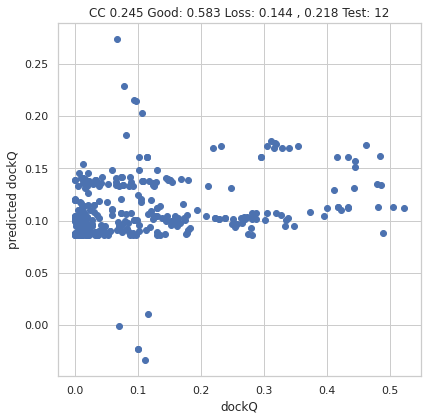

In [16]:
ydata=good_df.dockQ

#cols=["lenA","lenB","msa","long","med","longA","medA","longB","medB","tmA","tmB"]
#xdata=good_df[["lenA","lenB","long","med"]]
#cols=["longA","longB","medA","medB","tmA","tmB"]
cols=["med","long","msa"]
#cols=["msa"]
xdata=good_df[cols]
reg.fit(xdata,ydata)
ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
cc=np.corrcoef(ydata,ypred)
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")
(i,j,dockq,mm)=get_ranks(good_df,ypred)
#print(i,j,k/i)
ax.set_title("CC" + " " + str(round(cc[0,1],3))
            + " Good: " + str(round(j/i,3)) + " Loss: " + str(round(dockq/i,3))
             + " , " + str(round(mm/i,3))
             + " Test: " + str(i)
            )


In [17]:
xdata=df.loc[df.JHparams.isin(JHsets)][cols]
ypred = reg.predict(xdata)
df2=df.loc[df.JHparams.isin(JHsets)].reset_index()
df2.loc[:,'pred'] = ypred
topranked=pd.DataFrame(columns = df2.columns) 


In [18]:

for name in df2.name.unique():
    foo=df2.loc[df2.name==name].sort_values("pred")[-1:].max()
    #print(foo)
    foo_df=pd.DataFrame(foo).transpose()
    #print (foo_df)
    topranked=pd.concat([topranked,foo_df], ignore_index=True)
topranked["JHparams"]="JHranked"
topranked.params="JHranked"
topranked=topranked.drop(["pred","index"],axis=1)
topranked.columns

Index(['name', 'JHparams', 'lenA', 'lenB', 'msa', 'msaA', 'msaB', 'cdhit',
       'dockQ', 'fnat', 'iRMS', 'LRMS', 'fnonnat', 'mm', 'tmA', 'tmB', 'long',
       'med', 'longPPV', 'medPPV', 'longA', 'medA', 'longPPVA', 'medPPVA',
       'longB', 'medB', 'longPPVB', 'medPPVB', 'short', 'shortPPV', 'shortA',
       'shortPPVA', 'shortB', 'shortPPVB', 'shortpdb', 'medpdb', 'longpdb',
       'avprob', 'auc', 'evalue', 'seqid', 'hhprob', 'hhevalue', 'hhscore',
       'rank', 'code', 'CODE', 'params'],
      dtype='object')

In [19]:
df.columns

Index(['name', 'JHparams', 'lenA', 'lenB', 'msa', 'msaA', 'msaB', 'cdhit',
       'dockQ', 'fnat', 'iRMS', 'LRMS', 'fnonnat', 'mm', 'tmA', 'tmB', 'long',
       'med', 'longPPV', 'medPPV', 'longA', 'medA', 'longPPVA', 'medPPVA',
       'longB', 'medB', 'longPPVB', 'medPPVB', 'short', 'shortPPV', 'shortA',
       'shortPPVA', 'shortB', 'shortPPVB', 'shortpdb', 'medpdb', 'longpdb',
       'avprob', 'auc', 'evalue', 'seqid', 'hhprob', 'hhevalue', 'hhscore',
       'rank', 'code', 'CODE', 'params'],
      dtype='object')

In [20]:
df=pd.concat([df,topranked], ignore_index=True,sort=False)
df.fillna(0)
df.params.unique()

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3-cov90', 'N3dock',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA',
       'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'N5-newdockB',
       'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold', 'pdbcontacts-new',
       'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK',
       'PDBNEWDOCK-standard', 'pdbnewcontacts', 'PDBNEWDOCK-A',
       'PDBNEWDOCK-B', 'PDBNEWDOCK-C', 'PDBNEWDOCK-D',
       'PDBNEWDOCK-repulsion', 'pdbsurface', 'rbh-jh', 'rbh-merged-pdb',
       'rbh-merged', 'rbh', 'TMdock-nohomology-1.e-5', 'TMdock-double',
       'TMdock-nohomology', 'TMdock', 'trRosetta', 'PDB', 'JHranked'],
      dtype=object)

In [21]:
df

,name,JHparams,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,...,auc,evalue,seqid,hhprob,hhevalue,hhscore,rank,code,CODE,params
0,1ay7_u1_A-1ay7_u2_A,-N 3 --cpu 8,97,90,1060,1485,2034,1026,0.281,0.167,...,0.4,9999,0,0.4,0.4,0.4,1,1ay7,1ay7,-N 3 --cpu 8
1,1ay7_u2_A-1ay7_u1_A,-N 3 --cpu 8,90,97,1060,2034,1485,989,0.239,0.25,...,0.36,9999,0,0,9999,0,2,1ay7,1ay7,-N 3 --cpu 8
2,1b27_u1_A-1b27_u2_A,-N 3 --cpu 8,109,90,733,1484,2034,654,0.223,0.12,...,0.46,4.3,50,1.8,0.027,13.5,1,1b27,1b27,-N 3 --cpu 8
3,1b27_u2_A-1b27_u1_A,-N 3 --cpu 8,90,109,733,2034,1484,656,0.229,0.16,...,0.46,4.3,50,2.5,0.019,13.7,2,1b27,1b27,-N 3 --cpu 8
4,1bdj_u1_A-1bdj_u2_A,-N 3 --cpu 8,129,118,5651,349880,23051,5071,0,0,...,0,9999,0,0,9999,0,1,1bdj,1bdj,-N 3 --cpu 8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26453,5cec_u2_A-5cec_u1_A,JHranked,191,403,8,59695,200,7,0.05,0.075,...,0,19,33.333,0.3,0.21,14.5,2,5cec,5cec,JHranked
26454,5cra_u1_A-5cra_u2_A,JHranked,193,77,1,11,42026,1,0.008,0,...,0,9999,0,1.3,1.3,1.3,1,5cra,5cra,JHranked
26455,5cra_u2_A-5cra_u1_A,JHranked,77,193,1,42026,11,1,0.103,0,...,0.17,9999,0,1.1,1.1,1.1,2,5cra,5cra,JHranked
26456,5eg3_u1_A-5eg3_u2_A,JHranked,303,105,499,560629,26558,278,0,0,...,0,68,40,1,1,1,1,5eg3,5eg3,JHranked


In [22]:
#df["rank"].str.isnumeric().unique()
#df.dtypes

In [23]:
# We need to check that everything is numeric
cols=['name', 'JHparams', 'seqid',      'rank']

#for d in df.columns.values.tolist():
for d in ["rank","len"]:
    if d=="name": continue
    if d=="JHparams": continue
    print (d)
    #print (df.loc[(df[d].str.isnumeric()!=True)][cols+[d]])
    #print (df.loc[(df[d].str.isnumeric()][d].unique()
    #print (df[d].str.isnumeric().unique())

rank
len


In [ ]:
# Divide data into datasets


df["tmAB"]=df[["tmA","tmB"]].mean(axis=1)
df["msaAB"]=df[["msaA","msaB"]].mean(axis=1)
df["tmAB_max"]=df[["tmA","tmB"]].max(axis=1)
df["msaAB_max"]=df[["msaA","msaB"]].max(axis=1)
df["tmAB_min"]=df[["tmA","tmB"]].min(axis=1)
df["msaAB_min"]=df[["msaA","msaB"]].min(axis=1)
df["numcorrect"]=df["longPPV"]*df["long"]
df["len"]=df["lenA"]+df["lenB"]

codes=df.code.unique()
df_mean=df.groupby(["JHparams","code"]).mean()
df_max=df.groupby(["JHparams","code"]).max()
df_min=df.groupby(["JHparams","code"]).min()
df_first=df.loc[df["rank"]==1]

In [ ]:
df.columns.values.tolist()

In [ ]:
cols=['name', 'JHparams', 'seqid',      'rank']
      
d="TMdock-nohomology"
#df.loc[df.JHparams==d].groupby(["code"])[cols].first()

#df.loc[(df.JHparams==d) & ((df["rank"].str.isnumeric()!=True))][cols]
#df.loc[(df.JHparams==d)]["rank"].str.isnumeric()
#df.loc[(df.JHparams==d)] 
      
      

In [ ]:
datasets=df.JHparams.unique()
data_mean={}
data_max={}
data_min={}
for d in datasets:
    #print (d)
    data_mean[d]=df.loc[df.JHparams==d].groupby(["code"]).mean()
    data_max[d]=df.loc[df.JHparams==d].groupby(["code"]).max()
    data_min[d]=df.loc[df.JHparams==d].groupby(["code"]).min()


In [ ]:
df.loc[ (df.JHparams=="trRosetta")  & (df["rank"]==1)]

In [ ]:
df.JHparams.unique()
#datasets

In [ ]:
data_first={}
data_second={}
for d in datasets:
    data_first[d]=df.loc[ (df["JHparams"]==d)  & (df["rank"]==1)]
    data_second[d]=df.loc[ (df["JHparams"]==d)  & (df["rank"]==2)]
data_first[d]

In [ ]:
#datasets


In [ ]:
df_test= data_first["N1-merged"]
#data_first["N1-merged"].tmA
df_test["tmB"]


In [ ]:
df_merged = pd.merge(data_first["trRosetta"],data_first[d], on=['code'],how="inner")
plt.scatter(df_merged.dockQ,df_merged.mm)

In [ ]:

df_test= data_first["N1-merged"]
#plt.scatter(df_test.tmB,df_test.tmA)


sns_plot = sns.jointplot(data=df_test, x="tmA", y="tmB")
sns_plot.savefig("tmA-tmB.png")



In [ ]:
df_test.loc[(df_test.tmA>0.8 )&(df_test.lenA>300)]["name"]


In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
df_merged = pd.merge(data_max["PDB"],data_max["trRosetta"], on=['code'],how="inner")
plt.scatter(df_merged.tmAB_x,df_merged.tmAB_y,label=d)
ax.set_title("TM scores best model ")
ax.set_xlabel("TM PDB ")
ax.set_ylabel("TM trRosetta")



In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
    if d=="trRosetta":continue   
    #if d=="confold":continue   
    #if d=="rbh-merged-pdb":continue   

    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4] # +d
        except:
            sstr=df_merged.name_y[i][0:4] #+d
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.1]
y=[0,0.1]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores best model ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=5
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue 
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
        
    #if d=="confold":continue   
    #if d=="rbh-merged-pdb":continue   

    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.numcorrect_x,df_merged.numcorrect_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.numcorrect_x[i]> cutoff or df_merged.numcorrect_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.numcorrect_x[i], df_merged.numcorrect_y[i]))
x=[0,50]
y=[0,50]
plt.plot(x,y)
ax.legend()
ax.set_title("numcorrect scores best model ")
ax.set_xlabel("numcorrect "+str(datasets[0]))
ax.set_ylabel("numcorrect")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue   
    if d=="confold":continue   
    #if d=="rbh-merged-pdb":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first[datasets[0]],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.3]
y=[0,0.3]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (first ranked)  ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.1
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue   
    if d=="rbh merge pdb ":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
        
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.3]
y=[0,0.3]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["N1-top1000","-N 1 -E 1.e-10 --cpu 8 ","N1-merged-pdb"]:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue   
    if d=="rbh merge pdb ":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
        
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.6]
y=[0,0.6]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
data_max.keys()

In [ ]:
cutoff=0.23
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["N1-N3-new","TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (first)  ")
ax.set_xlabel("dockQ - gramm")
ax.set_ylabel("dockQ ")

plt.savefig("tr-tn-gramm.png")
#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
selset=['-N 3 --cpu 8', '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ',  '-N 1 -E 1.e-10 --cpu 8 ',  '-N 3 --incE 1.e-2', '-N 5 --cpu 8']
#codes=df_max.loc[df_max.params.isin(selset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=df.loc[(df.JHparams.isin(selset))]
plt.scatter(tempdf.msa,tempdf.dockQ)
plt.savefig("msa-dockq-scatter.png")
sns_plot=sns.jointplot(data=tempdf,x="msa",y="dockQ")
sns_plot.savefig("msa-dockq.png")


In [ ]:
tempdf=df.loc[(df.JHparams.isin(selset))]
plt.scatter(tempdf.msa,tempdf.tmA)
#print (tempdf["msaA"])
#tempdf["logmsaA"]=np.log10(tempdf["msa"]+0.0000001)
plt.savefig("msa-tm-scatter.png")
sns_plot=sns.jointplot(data=tempdf,x="msa",y="tmA")
sns_plot.savefig("msa-tm.png")


In [ ]:
cutoff=0.23
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta","TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ - gramm")
ax.set_ylabel("dockQ ")

plt.savefig("tr-tn-gramm-best.png")


In [ ]:
# FInd best method for each model.
selset=["gramm","TMdock-double","trRosetta"]
#codes=df_max.loc[df_max.params.isin(selset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=df.loc[(df.JHparams.isin(selset))&(df.rank==1)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(selset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_max.loc[(df_max.CODE.isin(codes))&(df_max.params.isin(selset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(selset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    print (d)
    
print (data)    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))
#sns.jointplot(data=df_merged,x=

plt.savefig("tm-tr-gramm-best-violin.png")


In [ ]:
# FInd best method for each model.
selset=["gramm","TMdock-double","N1-N3-new"]
#codes=df_max.loc[df_max.params.isin(selset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=df.loc[(df.JHparams.isin(selset))&(df.rank==1)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(selset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_first.loc[(df_first.CODE.isin(codes))&(df_first.params.isin(selset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("First ranked models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(selset):
    done[d]=0
    average[d]=all_df.loc[all_df.CODE.isin(codes)&(all_df.params==d)]["dockQ"].mean()
    length[d]=len(all_df.loc[all_df.CODE.isin(codes)&(all_df.params==d)]["dockQ"])
    pos+=[i]
    data+=[all_df.loc[all_df.CODE.isin(codes)&(all_df.params==d)]["dockQ"]]
    i+=1
    print (d)
print (data)    
ax.violinplot(data,pos)
#, points=80, vert=False, widths=0.7,
#                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))
#sns.jointplot(data=df_merged,x=

plt.savefig("tm-tr-gramm-violin.png")


In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ - gramm")
ax.set_ylabel("dockQ ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
d="TMdock"
foo=pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
data_first[d].dockQ
foo[["dockQ_x","dockQ_y"]]
#cc=np.corrcoef(foo.dockQ_x,foo.dockQ_y)

foo.dockQ_y.isna().unique()
data_first[d].dockQ.isna().unique()

In [ ]:
cutoff=0.1
#f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-double","trRosetta"]:
    #if d!="N1-merged":continue   
    print (d)
    df_merged = pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    #sns.jointplot(x="dockQ_x", y="dockQ_y", data=df_merged)
    print(df_merged.dockQ_x.shape[0],df_merged.dockQ_y.shape[0])
    #cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_x)
    #print (cc)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (first model) ") #, CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.1
#f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-nohomology"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    #sns.jointplot(x="dockQ_x", y="dockQ_y", data=df_merged)
    #cc=np.corrcoef(df_merged.dockQ_y,df_merged.dockQ_y)
    #print (cc)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (first model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock-nohomology")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (best model))" )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta","TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        #if (sstr=="3qc8" or sstr=="2hqs" or sstr=="3bs5" ):
        if (sstr=="1ay7" ):
            #if (df_merged.dockQ_y[i]> cutoff and (df_merged.dockQ_y[i]>df_merged.dockQ_x[i])):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (best model)") 
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
df_merged = df_max[df_max["params"].isin(["trRosetta","gramm","TMdock-double"])]
df_merged.sort_values("dockQ")

In [ ]:
len(df_merged.loc[df_merged.dockQ>0.2]["CODE"].unique())

In [ ]:
len(df_merged.loc[(df_merged.params=="trRosetta")&(df_merged.dockQ>0.2 )]["CODE"].unique())

In [ ]:
len(df_merged.loc[(df_merged.params=="gramm")&(df_merged.dockQ>0.2 )]["CODE"].unique())

In [ ]:
len(df_merged.loc[(df_merged.params=="TMdock-double")&(df_merged.dockQ>0.2 )]["CODE"].unique())

In [ ]:
len(df_merged["CODE"].unique())

In [ ]:
df.loc[df.params=="TMdock-double"].sort_values("dockQ")

In [ ]:
df_merged.groupby(["CODE"]).median().sort_values("dockQ")


In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    #cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (first model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["TMdock-nohomology"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ TMdock-nohomology")
ax.set_ylabel("dockQ TMdock "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["TMdock"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (best model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ TMdock")
ax.set_ylabel("dockQ TMdock "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=1.0
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDB|^pdb")
pdbset=list(filter(r.match, datasets))
pdbset=["pdbconfold"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts-new":continue
    df_merged = pd.merge(data_max["pdbcontacts-new"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)
plt.savefig("pdbconfold.png")
#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*step1.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("pdbconfold")
pdbset=list(filter(r.match, datasets))
pdbset=["PDB"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        #if (df_merged.dockQ_y[i]- df_merged.dockQ_x[i]>cutoff):
        #    ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ pdbcontacts")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("pdbconfold")
pdbset=list(filter(r.match, datasets))
pdbset=["pdbconfold"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["PDB"],data_max[d], on=['code'],how="outer")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        #if (df_merged.dockQ_y[i]- df_merged.dockQ_x[i]>cutoff):
        #    ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ PDB")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-[ABCD]$")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*dockB-relax.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*dockC-relax.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*dockD-relax.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-C.*-relax.*")
pdbset=list(filter(r.match, datasets))+["PDBNEWDOCK-C"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-C.*-relax.*")
pdbset=list(filter(r.match, datasets))+["PDBNEWDOCK-C"]
pdbset=["PDBNEWDOCK-B","PDBNEWDOCK-C","PDBNEWDOCK-A--dockC-relax",
        "PDBNEWDOCK-C--dockC-relax","PDBNEWDOCK-B--dockD-relax",
        "PDBNEWDOCK-C--dockD-relax"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts-new":continue
    df_merged = pd.merge(data_max["pdbcontacts-new"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-C.*-relax.*")
pdbset=list(filter(r.match, datasets))+["PDBNEWDOCK-C"]
pdbset=["pdbcontacts","pdbnewcontacts","PDBNEWDOCK-standard","PDBNEWDOCK-repulsion","pdbconfold"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    #if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["PDB"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
r=re.compile(".*relax.*")
#pdbset=list(filter(r.match, datasets))+['PDBNEWDOCK-A','PDBNEWDOCK-B', 'PDBNEWDOCK-C', 'PDBNEWDOCK-D',"pdbcontacts"]
pdbset=sorted(["PDB","PDBNEWDOCK-B","PDBNEWDOCK-C","PDBNEWDOCK-A--dockC-relax",
        "PDBNEWDOCK-C--dockC-relax","PDBNEWDOCK-B--dockD-relax",
        "PDBNEWDOCK-C--dockD-relax","pdbcontacts","pdbnewcontacts","PDBNEWDOCK-standard",
               "PDBNEWDOCK-repulsion","pdbconfold"])


smallset=["1ay7", "1b27", "1bvn", "1gcq", "1gpw", "1he1", "1i4e", "1i8l",
"1jiw", "1k5g", "1nql", "1vg0", "2aq3", "2b4s", "2d5r", "2grx",
"2hj9", "2hrk", "2ido", "2nqd", "2nxn", "2o3b", "2sge", "2wbw",
"2x9a", "2xwb", "2zae", "3a1p", "3a8i", "3bs5", "3buz", "3cw2",
"3cw2", "3fpu", "3lwn", "3ona", "3rnk", "3vlb", "3w31", "3wkt",
"4bi8", "4bmp", "4gmj", "4hcn", "4k0v", "4kyi", "4o4b", "4rf0",
"4xhu", "4yoc"]
codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
codes=smallset
codes=df_max.loc[(df_max.params=="PDBNEWDOCK-A--dockC-relax")&(df_max.params.isin(pdbset) )]["CODE"].unique()
codes=df_max.loc[(df_max.params=="PDBNEWDOCK-C")&(df_max.params.isin(pdbset) )]["CODE"].unique()

codes=smallset

In [ ]:
cutoff=0.2
newdf=df_max.loc[df_max.dockQ>cutoff]
newdf=newdf.reset_index()

In [ ]:
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_max.loc[(df_max.CODE.isin(codes))&(df_max.params.isin(pdbset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))


In [ ]:
datasets

In [ ]:
pdbset=[ 'N3dock',
       'N3-newdockA', 'N3-newdockB', 'N3-newdockC', 'N5-newdockA','N5-newdockB',
       'N5-newdockC', '-N 5 --cpu 8',"-N 3 --cpu 8"]
codes=df_max.loc[(df_max.params=="N3-newdockC")&(df_max.params.isin(pdbset) )]["CODE"].unique()
codes

In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="-N 3 --cpu 8":continue
    df_merged = pd.merge(data_max["-N 3 --cpu 8"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_max.loc[(df_max.CODE.isin(codes))&(df_max.params.isin(pdbset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    print (d,len(data[i]))
    i+=1
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))


In [ ]:
pdbset=sorted(["N1","N3"])

In [ ]:
for d in pdbset:
    print (d,len(df_max.loc[(df_max.params==d)]["CODE"].unique()))

In [ ]:
all_df

In [ ]:
cutoff=0.2
newdf=df_max.loc[df_max.dockQ>cutoff]
newdf=newdf.reset_index()


In [ ]:
datasets

In [ ]:
r=re.compile(".*relax.*")
pdbset=list(filter(r.match, datasets))+['PDBNEWDOCK-A','PDBNEWDOCK-B', 'PDBNEWDOCK-C', 'PDBNEWDOCK-D',"pdbcontacts","pdbconfold","PDB"]


smallset=["1ay7", "1b27", "1bvn", "1gcq", "1gpw", "1he1", "1i4e", "1i8l",
"1jiw", "1k5g", "1nql", "1vg0", "2aq3", "2b4s", "2d5r", "2grx",
"2hj9", "2hrk", "2ido", "2nqd", "2nxn", "2o3b", "2sge", "2wbw",
"2x9a", "2xwb", "2zae", "3a1p", "3a8i", "3bs5", "3buz", "3cw2",
"3cw2", "3fpu", "3lwn", "3ona", "3rnk", "3vlb", "3w31", "3wkt",
"4bi8", "4bmp", "4gmj", "4hcn", "4k0v", "4kyi", "4o4b", "4rf0",
"4xhu", "4yoc"]
codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
codes=smallset
codes=df_max.loc[(df_max.params=="PDBNEWDOCK-A")&(df_max.params.isin(pdbset) )]["CODE"].unique()


In [ ]:
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_max.loc[(df_max.CODE.isin(codes))&(df_max.params.isin(pdbset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    #print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))


In [ ]:
codes

In [ ]:
all_df

In [ ]:
# FInd best method for each model.
codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
plt.scatter(best_df.dockQ,best_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    #print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[best_df.JHparams[i]]==0:
        done[best_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[best_df.JHparams[i]],3))+"("+str(length[good_df.JHparams[i]])+")"
                    ,(1.0, best_df.JHparams[i]))
for d in datasets:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[good_df.JHparams[i]]==0:
        done[good_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.1, good_df.JHparams[i]))
        #ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        #ax.annotate("("+str(length[good_df.JHparams[i]])+")",(1.2, good_df.JHparams[i]))


In [ ]:
compareset=["trRosetta","gramm","TMdock-double"]
codes=df_max.loc[df_max.params.isin(compareset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(compareset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(compareset))].reset_index()
plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
plt.scatter(best_df.dockQ,best_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(compareset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    #print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[best_df.JHparams[i]]==0:
        done[best_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        #ax.annotate(str(round(average[best_df.JHparams[i]],3))+
        #            "("+str(length[good_df.JHparams[i]])+")"
        #            ,(1.0, best_df.JHparams[i]))
for d in datasets:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[good_df.JHparams[i]]==0:
        done[good_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.1, good_df.JHparams[i]))
        #ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        #ax.annotate("("+str(length[good_df.JHparams[i]])+")",(1.2, good_df.JHparams[i]))


In [ ]:
best_df

In [ ]:
codes

In [ ]:

f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(newdf.dockQ,newdf.JHparams)
#cc=np.corrcoef(newdf.dockQ,newdf.len)
ax.set_title("Good  models")
ax.set_xlabel("JHparams")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
for d in datasets:
    done[d]=0
for i, txt in enumerate(newdf.name):
    #print (i,txt)
    sstr=txt[0:4]
    ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(newdf.loc[newdf.JHparams==newdf.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[newdf.JHparams[i]]==0:
        done[newdf.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, newdf.JHparams[i]))

In [ ]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(newdf.dockQ,newdf.JHparams)
#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Good models")
ax.set_xlabel("dockQ")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
for d in datasets:
    done[d]=0
for i, txt in enumerate(newdf.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(newdf.loc[newdf.JHparams==newdf.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[newdf.JHparams[i]]==0:
        done[newdf.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, newdf.JHparams[i]))

In [ ]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(newdf.dockQ,newdf.JHparams)
#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Good models")
ax.set_xlabel("dockQ")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
for d in datasets:
    done[d]=0
for i, txt in enumerate(newdf.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(newdf.loc[newdf.JHparams==newdf.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[newdf.JHparams[i]]==0:
        done[newdf.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, newdf.JHparams[i]))

In [ ]:
datasets

In [ ]:
# here we find what method is best for each target

r = re.compile("^PDB.*|^TMd.*|^gramm|trRosetta|^pdb.*")
excludecolumns = list(filter(r.match, datasets)) # Read Note
print(excludecolumns)
excludecolumns+=["confold","rbh-merged-pdb"]
tempdf=newdf.loc[~newdf.JHparams.isin(excludecolumns)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

In [ ]:
# FInd best method for each model.
codes=best_df["code"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
good_df=newdf.loc[(newdf.code.isin(codes))&(~newdf.JHparams.isin(excludecolumns))].reset_index()
plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
plt.scatter(best_df.dockQ,best_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_xlabel("Method")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
for d in datasets:
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[best_df.JHparams[i]]==0:
        done[best_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[best_df.JHparams[i]],3)),(1.0, best_df.JHparams[i]))
        ax.annotate(str(length[best_df.JHparams[i]]),(.9, best_df.JHparams[i]))
for d in datasets:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[good_df.JHparams[i]]==0:
        done[good_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.1, good_df.JHparams[i]))
        ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        ax.annotate(str(length[good_df.JHparams[i]]),(.9, good_df.JHparams[i]))


In [ ]:
df.sort_values('dockQ', ascending=False).drop_duplicates(["code"])

In [ ]:
df.loc[(df.dockQ>cutoff) & (~df.JHparams.isin(excludecolumns))].groupby("name").max()


In [ ]:
r = re.compile("^PDB.*|^TMd.*|^gramm|trRosetta|^pdb.*")
excludecolumns = list(filter(r.match, datasets)) # Read Note
print (excludecolumns)
includeTR=["pdbcontacts","PDBDOCK","TMdock-double"]
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best methods")

new_df=df.loc[(df.dockQ>cutoff) & (~df.JHparams.isin(excludecolumns))].sort_values('dockQ', ascending=False).drop_duplicates(["code"]).reset_index()
codes=new_df.CODE.unique()
#print(new_df)
#newdf.sort_values(["JHparams","dockQ","code"],inplace=True)

tempdf=df_max.loc[(df_max.CODE.isin(codes)) & (~df_max.params.isin(includeTR))].reset_index()
plt.scatter(tempdf.dockQ,tempdf.params,color="grey")
#print(tempdf[tempdf.params=="N1-top1000"])
plt.scatter(new_df.dockQ,new_df.params,color="red")
#print(new_df[new_df.params=="N1-top1000"])

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Average scores for good models")
ax.set_xlabel("dockQ")
ax.set_ylabel("Method")
ax.set(xlim=[0,1])
done={}
average={}
length={}
ax.set(xlim=[0,1.5])
for d in datasets: #~df.JHparams.isin(excludecolumns).unique():
    done[d]=0
    average[d]=df_max.loc[(df_max.CODE.isin(codes)) & (df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[(df_max.CODE.isin(codes)) & (df_max.params==d)]["dockQ"])
for i, txt in enumerate(tempdf.name):
    #print (i,txt, newdf.JHparams[i])
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(tempdf.loc[(tempdf.params==tempdf.params[i])&(tempdf.dockQ>cutoff)])
    
    #print (numhit,newdf.JHparams[i])
    if done[tempdf.params[i]]==0:
        done[tempdf.params[i]]=1
        ax.annotate(str(numhit),(1.1, tempdf.params[i]))
        #ax.annotate("0",(.1, tempdf.JHparams[i]))  
        ax.annotate(str(round(average[tempdf.params[i]],3)),(.9, tempdf.params[i]))          
        ax.annotate(str(round(length[tempdf.params[i]],3)),(.75, tempdf.params[i]))  
for d in datasets: #~df.JHparams.isin(excludecolumns).unique():
    done[d]=0
for i, txt in enumerate(new_df.name):
    #print (i,txt,newdf.dockQ[i], newdf.JHparams[i])
    sstr=txt[0:4]
    ax.annotate(sstr, (new_df.dockQ[i], new_df.params[i]))
    numhit=len(new_df.loc[new_df.params==new_df.params[i]])
    #numhit2=len(tempdf.loc[tempdf.JHparams==tempdf.params[i]])
    #print (numhit,newdf.JHparams[i])
    if done[new_df.params[i]]==0:
        done[new_df.params[i]]=1
        ax.annotate(str(numhit),(1.3, new_df.params[i]))  
        #ax.annotate(str(numhit2),(-0.1, new_df.JHparams[i]))


In [ ]:
cutoff=0.1

In [ ]:
JHsets=['-N 3 --cpu 8', 
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged',
       'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500',  '-N 5 --cpu 8']

cutoff=0.1

In [ ]:
goodmodels=df_max.loc[(df_max.dockQ>cutoff)&(df_max.params.isin(JHsets)) ]["CODE"].unique()

In [ ]:
tempdf=df_max.loc[df_max.params.isin(JHsets)] 


tempdf=tempdf.loc[tempdf.CODE.isin(goodmodels)]
cf={"dockQ":0.2,"mm":0.6,"numcorrect":50}
for y in ["numcorrect","msa","tmAB","msa","long","med"]:
    for x in ["dockQ","mm","numcorrect"]:
        cutoff=cf[x]
        #print (Name)
         #if (Name != "lenA"):
        #    continue
        f, ax = plt.subplots(figsize=(6.5, 6.5))
        for d in JHsets:
            xdata=tempdf.loc[tempdf.params==d][x]
            ydata=tempdf.loc[tempdf.params==d][y]
            plt.scatter(xdata,ydata,label=d)
            cc=np.corrcoef(xdata,ydata)
            for i, txt in enumerate(tempdf.loc[tempdf.params==d].name):
                sstr=txt[0:4]
                if (xdata[i]>cutoff):
                    ax.annotate(sstr, (xdata[i], ydata[i]))
        ax.set_title(x + " - " + y )
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.legend()
    plt.close()

In [ ]:
datasets

In [ ]:
goodmodels

In [ ]:
tempdf=df_max.loc[df_max.CODE.isin(codes)&(df_max.params.isin(pdbset))]
tempdf

In [ ]:
df_max.loc[df_max.params=="N3-multimerged"]["dockQ"]

In [ ]:
pdbset=['-N 3 --cpu 8', "-N 1 -E 1.e-2 " ,"N1-N3-new"]
cutoff=0.2
codes=goodmodels
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
#tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]
tempdf=df_max.loc[df_max.CODE.isin(codes)&(df_max.params.isin(pdbset))]
#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['CODE']).reset_index()
best_df.sort_values("params")

#good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
good_df=df_max.loc[df_max.CODE.isin(codes)&(df_max.params.isin(pdbset))&(df_max.dockQ>cutoff )].reset_index()

plt.scatter(good_df.dockQ,good_df.params,color="grey")
plt.scatter(best_df.dockQ,best_df.params,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.params==best_df.params[i]])
    #print (numhit,newdf.params[i])
    if done[best_df.params[i]]==0:
        done[best_df.params[i]]=1
        ax.annotate(str(numhit),(.0, best_df.params[i]))
        ax.annotate(str(round(average[best_df.params[i]],3))+"("+str(length[good_df.params[i]])+")"
                    ,(1.0, best_df.params[i]))
for d in pdbset:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.params[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.params[i]])
    #print (numhit,newdf.params[i])
    if done[good_df.params[i]]==0:
        done[good_df.params[i]]=1
        ax.annotate(str(numhit),(.1, good_df.params[i]))
        #ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        #ax.annotate("("+str(length[good_df.JHparams[i]])+")",(1.2, good_df.JHparams[i]))
plt.savefig("N1-N3-violin.png")


In [ ]:
#data_dirst


In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
baseset="N1-N3-new"
for d in pdbset:
  
    if d==baseset:continue   
    #print (d)
    df_merged = pd.merge(data_first[baseset],data_first[d], on=['CODE'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.5]
y=[0,0.5]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (first ranked)  ")
ax.set_xlabel("dockQ "+baseset)
ax.set_ylabel("dockQ")
plt.savefig("N1-N3-scatter.png")
#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in JHsets:
  
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first[datasets[0]],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    #plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
#x=[0,0.3]
#y=[0,0.3]
#plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (first ranked)  ")
ax.set_xlabel("dockQ N1-N3 ")
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [ ]:
goodmodels

In [ ]:
JHsets

In [ ]:
JHsets1=['-N 3 --cpu 8',
 '-N 1 -E 1.e-100 --cpu 8',
 '-N 1 -E 1.e-2 ',
 'N1-merged-pdb',
 'N1-merged',
 '-N 1 -E 1.e-10 --cpu 8 ']

In [ ]:
JHsets2=[
 'N1-top1000-merged',
 'N1-top1000',
 'N1-top100',
 'N1-top2000',
 'N1-top500',
 '-N 5 --cpu 8']

In [ ]:
JHsets=['-N 3 --cpu 8',
 '-N 1 -E 1.e-2 --cpu 8',
 '-N 1 -E 1.e-10 --cpu 8 ',
 '-N 5 --cpu 8']
good_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets))].reset_index()


In [ ]:
train_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets1))].reset_index()
test_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets2))].reset_index()

In [ ]:
good_df=df_first.loc[(df_first.code.isin(goodmodels)&(df_first.JHparams.isin(JHsets)))].reset_index()

In [ ]:
good_df=df_first.loc[(df_first.JHparams.isin(JHsets))].reset_index()

In [ ]:
good_df

In [ ]:
cutoff

In [ ]:
ydata=good_df.dockQ
cols=["lenA","lenB","msa","long","med","longA","medA","longB","medB","tmA","tmB"]

#xdata=good_df[["lenA","lenB","long","med"]]
#cols=["longA","longB","medA","medB","tmA","tmB"]
cols=["med","long","msa"]
#cols=["msa"]
xdata=good_df[cols]


reg.fit(xdata,ydata)
ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
cc=np.corrcoef(ydata,ypred)
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")
(i,j,dockq,mm)=get_ranks(good_df,ypred)
#print(i,j,k/i)
ax.set_title("CC" + " " + str(round(cc[0,1],3))
            + " Good: " + str(round(j/i,3)) + " Loss: " + str(round(dockq/i,3))
             + " , " + str(round(mm/i,3))
             + " Test: " + str(i)
            )


In [ ]:
print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

In [ ]:

for s in JHsets:
    set_df=good_df.loc[good_df.params==s]
    ypred=set_df["dockQ"].to_list()
    (i,j,dockq,mm)=get_ranks(set_df,ypred)
    print (s,i,j,dockq,mm)

In [ ]:
xdata=good_df[cols]
ydata=good_df.dockQ

ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
cc=np.corrcoef(ydata,ypred)
ax.set_title("CC" + " " + str(cc[0,1]))
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")


In [ ]:
good_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets))].reset_index()
good_df

In [ ]:
# Now we try all combinations - no plots
set1_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets1))].reset_index()
set2_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets2))].reset_index()
good_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets))].reset_index()

cols=["lenA","lenB","msa","long","med","longA","medA","longB","medB","tmA","tmB"]
ydata=good_df.dockQ

res={}
maxvalue=0
for c in cols:
    xdata=good_df[[c]]
    reg.fit(xdata,ydata)
    ypred = reg.predict(xdata)
    print (c,round(np.corrcoef(ydata,ypred)[0,1],3))
    res[c]=np.corrcoef(ydata,ypred)[0,1]
    maxvalue=max(res[c],maxvalue)    
for c in cols:
    for d in cols:
        xdata=good_df[[c,d]]
        reg.fit(xdata,ydata)
        ypred = reg.predict(xdata)
        #print (c,d,round(np.corrcoef(ydata,ypred)[0,1],3))
        res[c+d]=np.corrcoef(ydata,ypred)[0,1]
        #if (res[c+d]-maxvalue>0.0):
        #    print (c,d,round(np.corrcoef(ydata,ypred)[0,1],3))
        (i,j,k,l)=get_ranks(good_df,ypred)
        print (c,d,i,j,k,l)

In [ ]:

print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)


In [ ]:
ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
#cc=np.corrcoef(ydata,ypred)
ax.set_title("CC" + " " + str(cc[0,1]))
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")


In [ ]:
newdf=df.loc[df.JHparams=="trRosetta"]
plt.scatter(newdf.csv,newdf.)

In [ ]:
newdf[["CODE","dockQ","csv","tmAB","long"]].sort_values("csv")

In [ ]:
JHsets=['-N 3 --cpu 8', 
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged',
       'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500',  '-N 5 --cpu 8']


In [ ]:
newdf=df.loc[(df.CODE=="4etw")&(df.JHparams.isin(JHsets))].reset_index()
fig, ax1 = plt.subplots()
ax1.set_xlabel('dockQ')
ax1.scatter(newdf.dockQ,newdf.JHparams)
ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis
ax2.scatter(newdf.long,newdf.JHparams,color="red")
ax2.tick_params(axis='x', labelcolor="red")
ax2.set_xlabel('cdhit')

In [ ]:
newdf=df.loc[(df.CODE=="4gmj")&(df.JHparams.isin(JHsets))].reset_index()
fig, ax1 = plt.subplots()
ax1.set_xlabel('dockQ')
ax1.scatter(newdf.dockQ,newdf.JHparams)
ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis
ax2.scatter(newdf.long,newdf.JHparams,color="red")
ax2.tick_params(axis='x', labelcolor="red")
ax2.set_xlabel('cdhit')

# bes models to test 2zae 4gmj
# Bad model 4etw

In [ ]:
df_max.loc[(df_max.params=="trRosetta") & (df_max.dockQ==0)]

In [ ]:
df_test= data_first["-N 3 --cpu 8"]
df_test["logEvalue"]=np.log10(df_test.evalue.astype('float64')).clip(+10,-10)
df_test["logHHEvalue"]=np.log10(df_test.hhevalue.astype('float64')).clip(+10,-10)
#plt.scatter(df_test.tmB,df_test.tmA)
cutoff=0.5
num=len(df_test.loc[df_test.hhprob>cutoff])
tot=len(df_test)


print (num,tot)
print (df_test.hhprob)
print (df_test.seqid)
print (df_test.logEvalue)
print (df_test.dockQ)

sns_plot = sns.jointplot(data=df_test, x="hhprob", y="logEvalue",hue="dockQ")
#sns_plot.title("Homologous pairs: "+str(num)+" of "+str(tot))
sns_plot.savefig("hhpred-logEvalue.png")





In [ ]:
sns_plot = sns.jointplot(data=df_test, x="hhprob", y="seqid") # ,hue="dockQ")
#sns_plot = sns.displot(data=df_test, x="hhprob", y="seqid" ,hue="dockQ")
#.set_title("Homologous pairs: "+str(num)+" of "+str(tot))
sns_plot.savefig("hhpred-seqid.png")


In [ ]:
df_test["Long"]=(df_test.long.astype('float64')).clip(0,500)
df_test["LogLong"]=np.log10(df_test.long.astype('float64')).clip(0,2.5)
sns_plot = sns.jointplot(data=df_test, x="hhprob", y="LogLong" ,hue="dockQ")
sns_plot.savefig("hhpred-long.png")
